In [92]:
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from burst_detection import extract_bursts
from matplotlib import pyplot as plt
import pandas as pd
import os.path as op
import mne
import scipy.io
import os
from mne.io import read_epochs_fieldtrip
from mne import create_info
import numpy as np
import mat73
import json
from scipy.stats import binned_statistic, pearsonr, linregress
from scipy.stats import spearmanr
from fastdtw import fastdtw
from dtaidistance import dtw
import seaborn as sns
from dtw import *
import csv

In [93]:
file_path = 'merged_bursts_three.json'
with open(file_path, 'r') as json_file:
    try:
        burst_three = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [94]:
list(burst_three[0]['bursts'].keys())

['trial',
 'waveform',
 'peak_freq',
 'peak_amp_iter',
 'peak_amp_base',
 'peak_time',
 'peak_adjustment',
 'fwhm_freq',
 'fwhm_time',
 'polarity',
 'waveform_times']

In [95]:
from collections import defaultdict
import statistics

# Dictionnaire pour stocker les bursts par epoch et trial
epoch_trial_bursts = defaultdict(lambda: defaultdict(int))

for ch_bursts in burst_three:
    epoch = ch_bursts['epoch']
    trials = ch_bursts['bursts']['trial']
    
    # Compter les bursts par trial
    for t in trials:
        epoch_trial_bursts[epoch][t] += 1

# Calculer la moyenne de bursts par trial, par epoch
for epoch, trials_dict in epoch_trial_bursts.items():
    counts = list(trials_dict.values())
    moyenne = statistics.mean(counts) if counts else 0
    print(f"Moyenne de bursts par trial pour l'epoch {epoch} : {moyenne}")


Moyenne de bursts par trial pour l'epoch go : 1649.8260869565217
Moyenne de bursts par trial pour l'epoch grsp : 479.94736842105266


In [96]:
flat_three_bursts={}
for key in burst_three[9]:
    if not key=='bursts':
        flat_three_bursts[key]=[]
    for sub_key in burst_three[9]['bursts']:
        flat_three_bursts[sub_key]=[]

for ch_bursts in burst_three:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_three_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_three_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_three_bursts['waveform']=np.vstack(flat_three_bursts['waveform'])
flat_three_bursts['waveform_times']=burst_three[9]['bursts']['waveform_times']

In [97]:
three_waveforms = flat_three_bursts['waveform']
three_waveform_times=np.array(flat_three_bursts['waveform_times'])

In [98]:
three_model = PCA(n_components=20)
three_scaler = RobustScaler().fit(three_waveforms)
three_waveform_std = three_scaler.transform(three_waveforms)
three_model_model = three_model.fit(three_waveform_std)
three_pc_scores = three_model.transform(three_waveform_std) # all the bursts x 20 components 

In [99]:
three_pc_labels = ["PC_{}".format(i+1) for i in range(three_pc_scores.shape[1])]

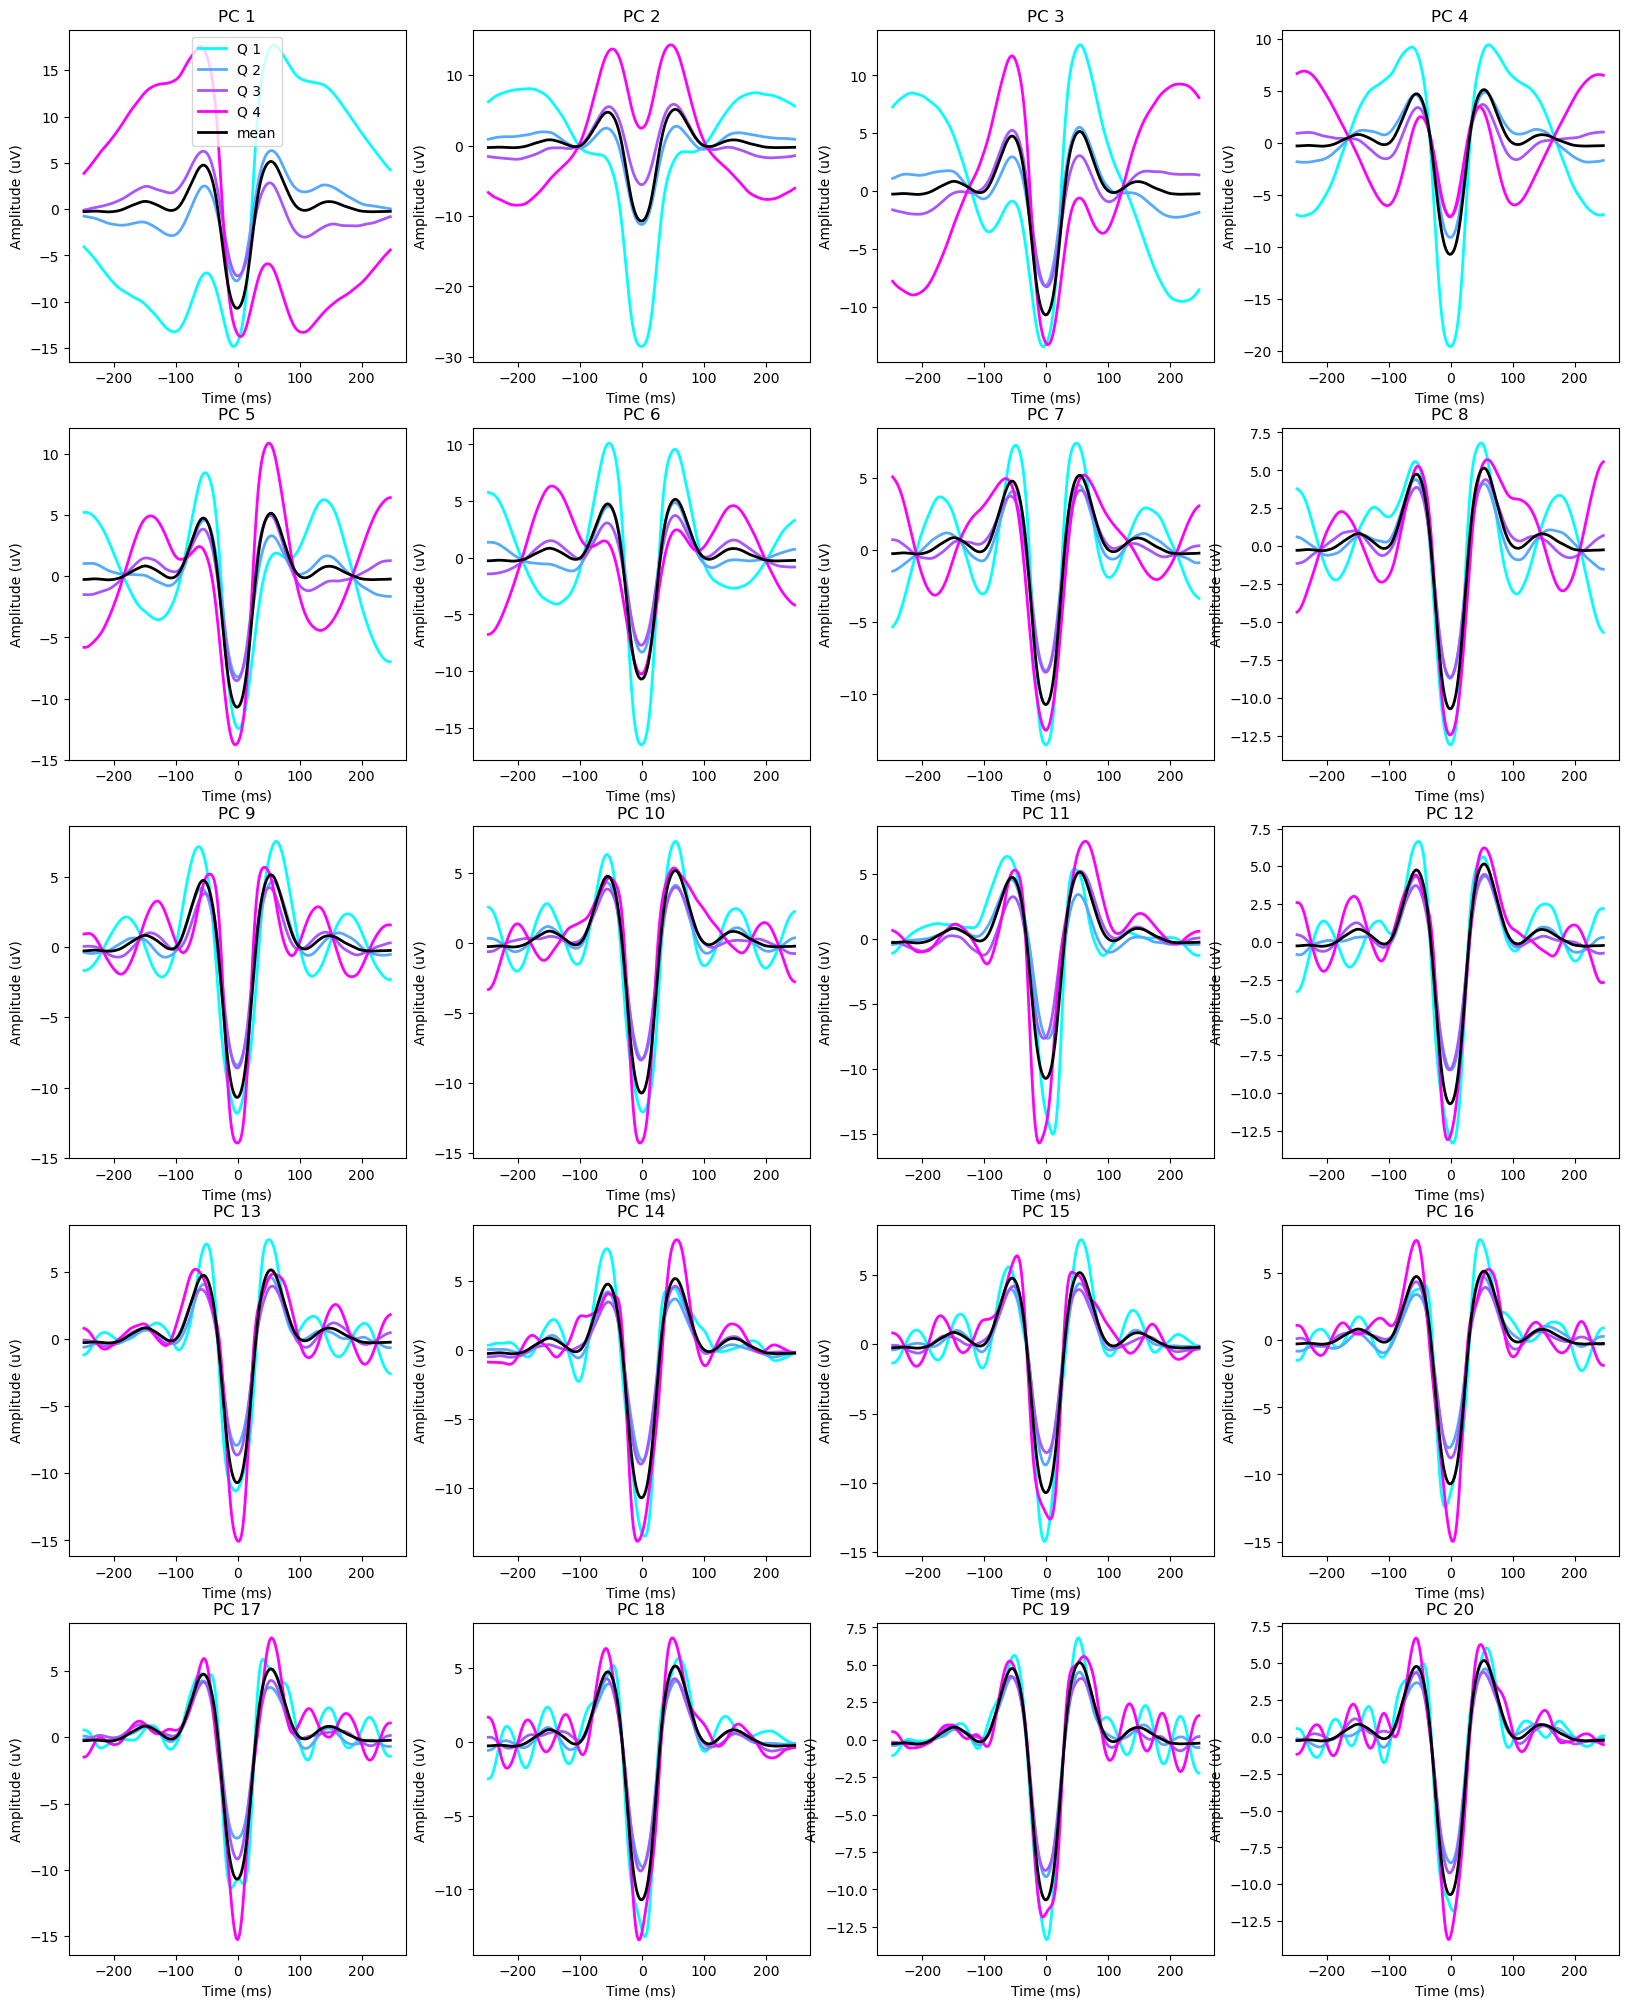

In [100]:
three_quartiles = np.linspace(0,100, num=5)
three_quartiles = list(zip(three_quartiles[:-1], three_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(three_quartiles)))
mean_waveform_three = np.mean(three_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(three_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = three_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(three_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(three_waveforms[q_map], axis=0)
        ax[pc_ix].plot(three_waveform_times*1000, q_mean*1e6, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(three_waveform_times*1000, mean_waveform_three*1e6, lw=2, c="black", label="mean")
    ax[pc_ix].set_xlabel('Time (ms)')
    ax[pc_ix].set_ylabel('Amplitude (uV)')
    #ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)
f.savefig('pc_plot_three_merged.png', dpi=300)

In [101]:
file_path = 'merged_bursts_six.json'
with open(file_path, 'r') as json_file:
    try:
        burst_six = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [102]:
flat_six_bursts={}
for key in burst_six[0]:
    if not key=='bursts':
        flat_six_bursts[key]=[]
    for sub_key in burst_six[0]['bursts']:
        flat_six_bursts[sub_key]=[]

for ch_bursts in burst_six:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_six_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_six_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_six_bursts['waveform']=np.vstack(flat_six_bursts['waveform'])
for subj_bursts in burst_six:
    if len(subj_bursts['bursts']['waveform_times']):
        flat_six_bursts['waveform_times']=subj_bursts['bursts']['waveform_times']
        break

In [103]:
six_waveforms = flat_six_bursts['waveform']
six_waveform_times = np.array(flat_six_bursts['waveform_times'])

In [104]:
six_model = PCA(n_components=20)
six_scaler = RobustScaler().fit(six_waveforms)
six_waveform_std = six_scaler.transform(six_waveforms)
six_model_model = six_model.fit(six_waveform_std)
six_pc_scores = six_model.transform(six_waveform_std) # all the bursts x 20 components 

In [105]:
six_pc_labels = ["PC_{}".format(i+1) for i in range(six_pc_scores.shape[1])]

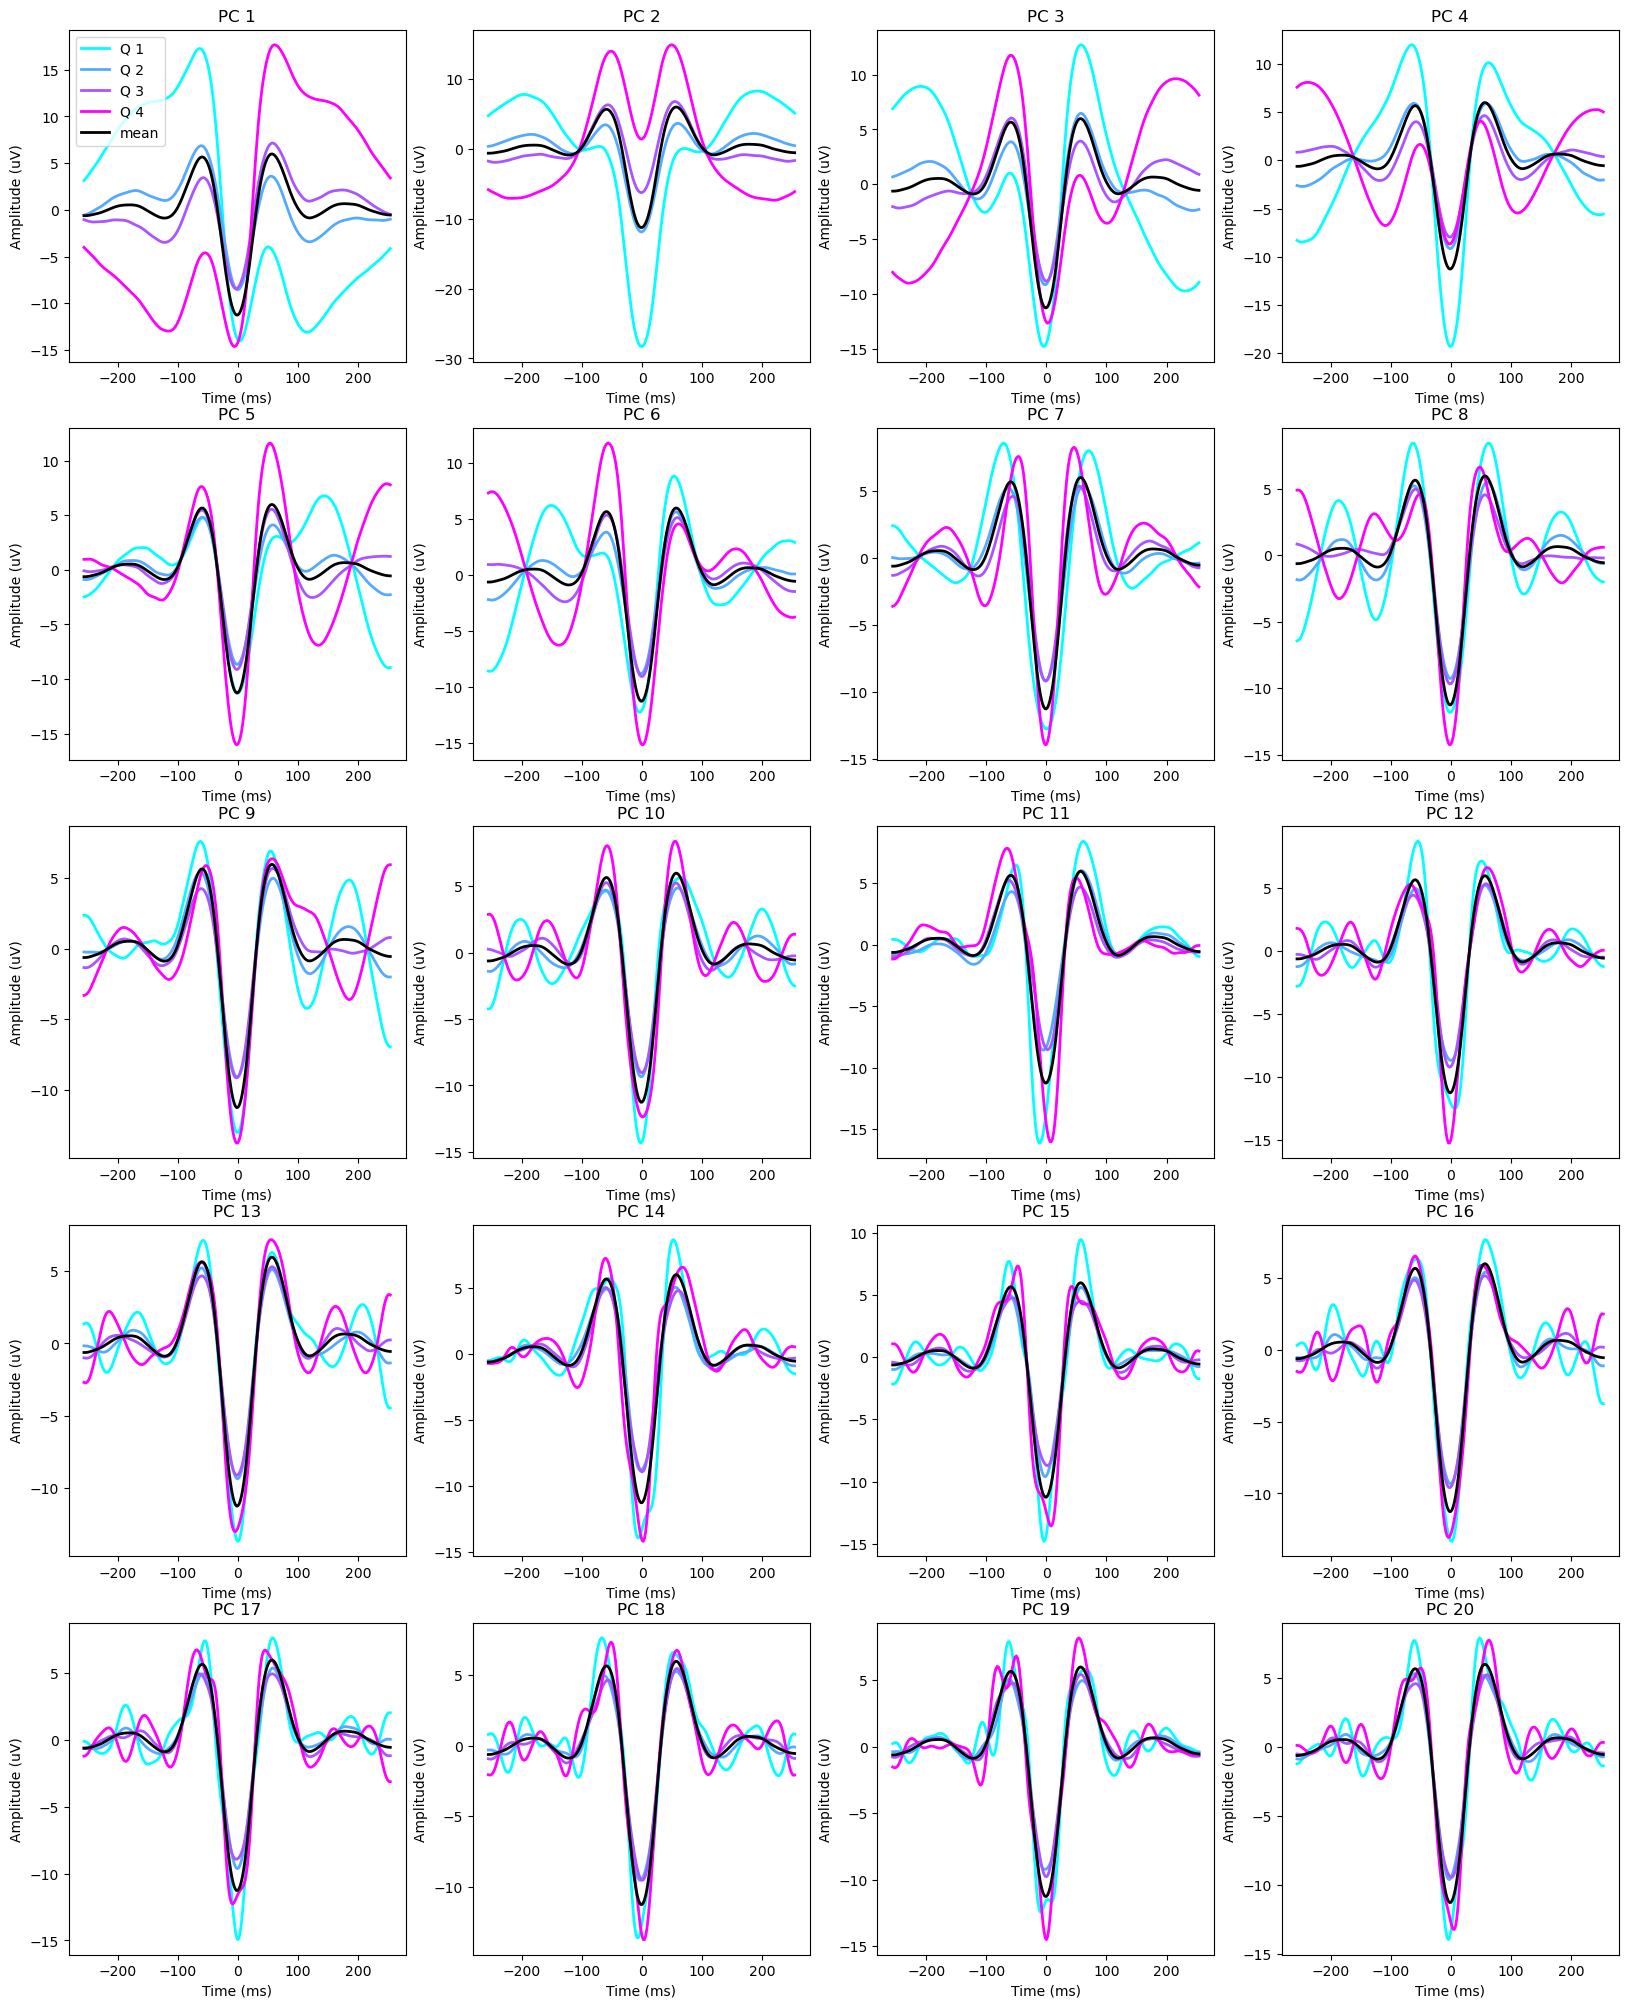

In [106]:
six_quartiles = np.linspace(0,100, num=5)
six_quartiles = list(zip(six_quartiles[:-1], six_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(six_quartiles)))
mean_waveform_six= np.mean(six_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(six_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = six_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(six_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(six_waveforms[q_map], axis=0)
        ax[pc_ix].plot(six_waveform_times*1000, q_mean*1e6, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(six_waveform_times*1000, mean_waveform_six*1e6, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
    ax[pc_ix].set_xlabel('Time (ms)')
    ax[pc_ix].set_ylabel('Amplitude (uV)')
ax[0].legend(fontsize=10)
f.savefig('pc_plot_six_merged.png', dpi=300)

In [107]:
file_path = 'merged_bursts_twelve.json'
with open(file_path, 'r') as json_file:
    try:
        burst_twelve = json.load(json_file)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from file {file_path}: {e}")

In [108]:
flat_twelve_bursts={}
for key in burst_twelve[0]:
    if not key=='bursts':
        flat_twelve_bursts[key]=[]
    for sub_key in burst_twelve[0]['bursts']:
        flat_twelve_bursts[sub_key]=[]

for ch_bursts in burst_twelve:
    n_bursts=len(ch_bursts['bursts']['trial'])
    for key in ch_bursts:
        if not key=='bursts':
            for x in range(n_bursts):
                flat_twelve_bursts[key].append(ch_bursts[key]) 
        else:
            for sub_key in ch_bursts['bursts']:
                if not sub_key=='waveform_times':
                    flat_twelve_bursts[sub_key].extend(ch_bursts['bursts'][sub_key])
flat_twelve_bursts['waveform']=np.vstack(flat_twelve_bursts['waveform'])
for subj_bursts in burst_twelve:
    if len(subj_bursts['bursts']['waveform_times']):
        flat_twelve_bursts['waveform_times']=subj_bursts['bursts']['waveform_times']
        break

In [109]:
twelve_waveforms = flat_twelve_bursts['waveform']
twelve_waveform_times=np.array(flat_twelve_bursts['waveform_times'])

In [110]:
twelve_model = PCA(n_components=20)
twelve_scaler = RobustScaler().fit(twelve_waveforms)
twelve_waveform_std = twelve_scaler.transform(twelve_waveforms)
twelve_model_model = twelve_model.fit(twelve_waveform_std)
twelve_pc_scores = twelve_model.transform(twelve_waveform_std) # all the bursts x 20 components 

In [111]:
twelve_pc_labels = ["PC_{}".format(i+1) for i in range(twelve_pc_scores.shape[1])]

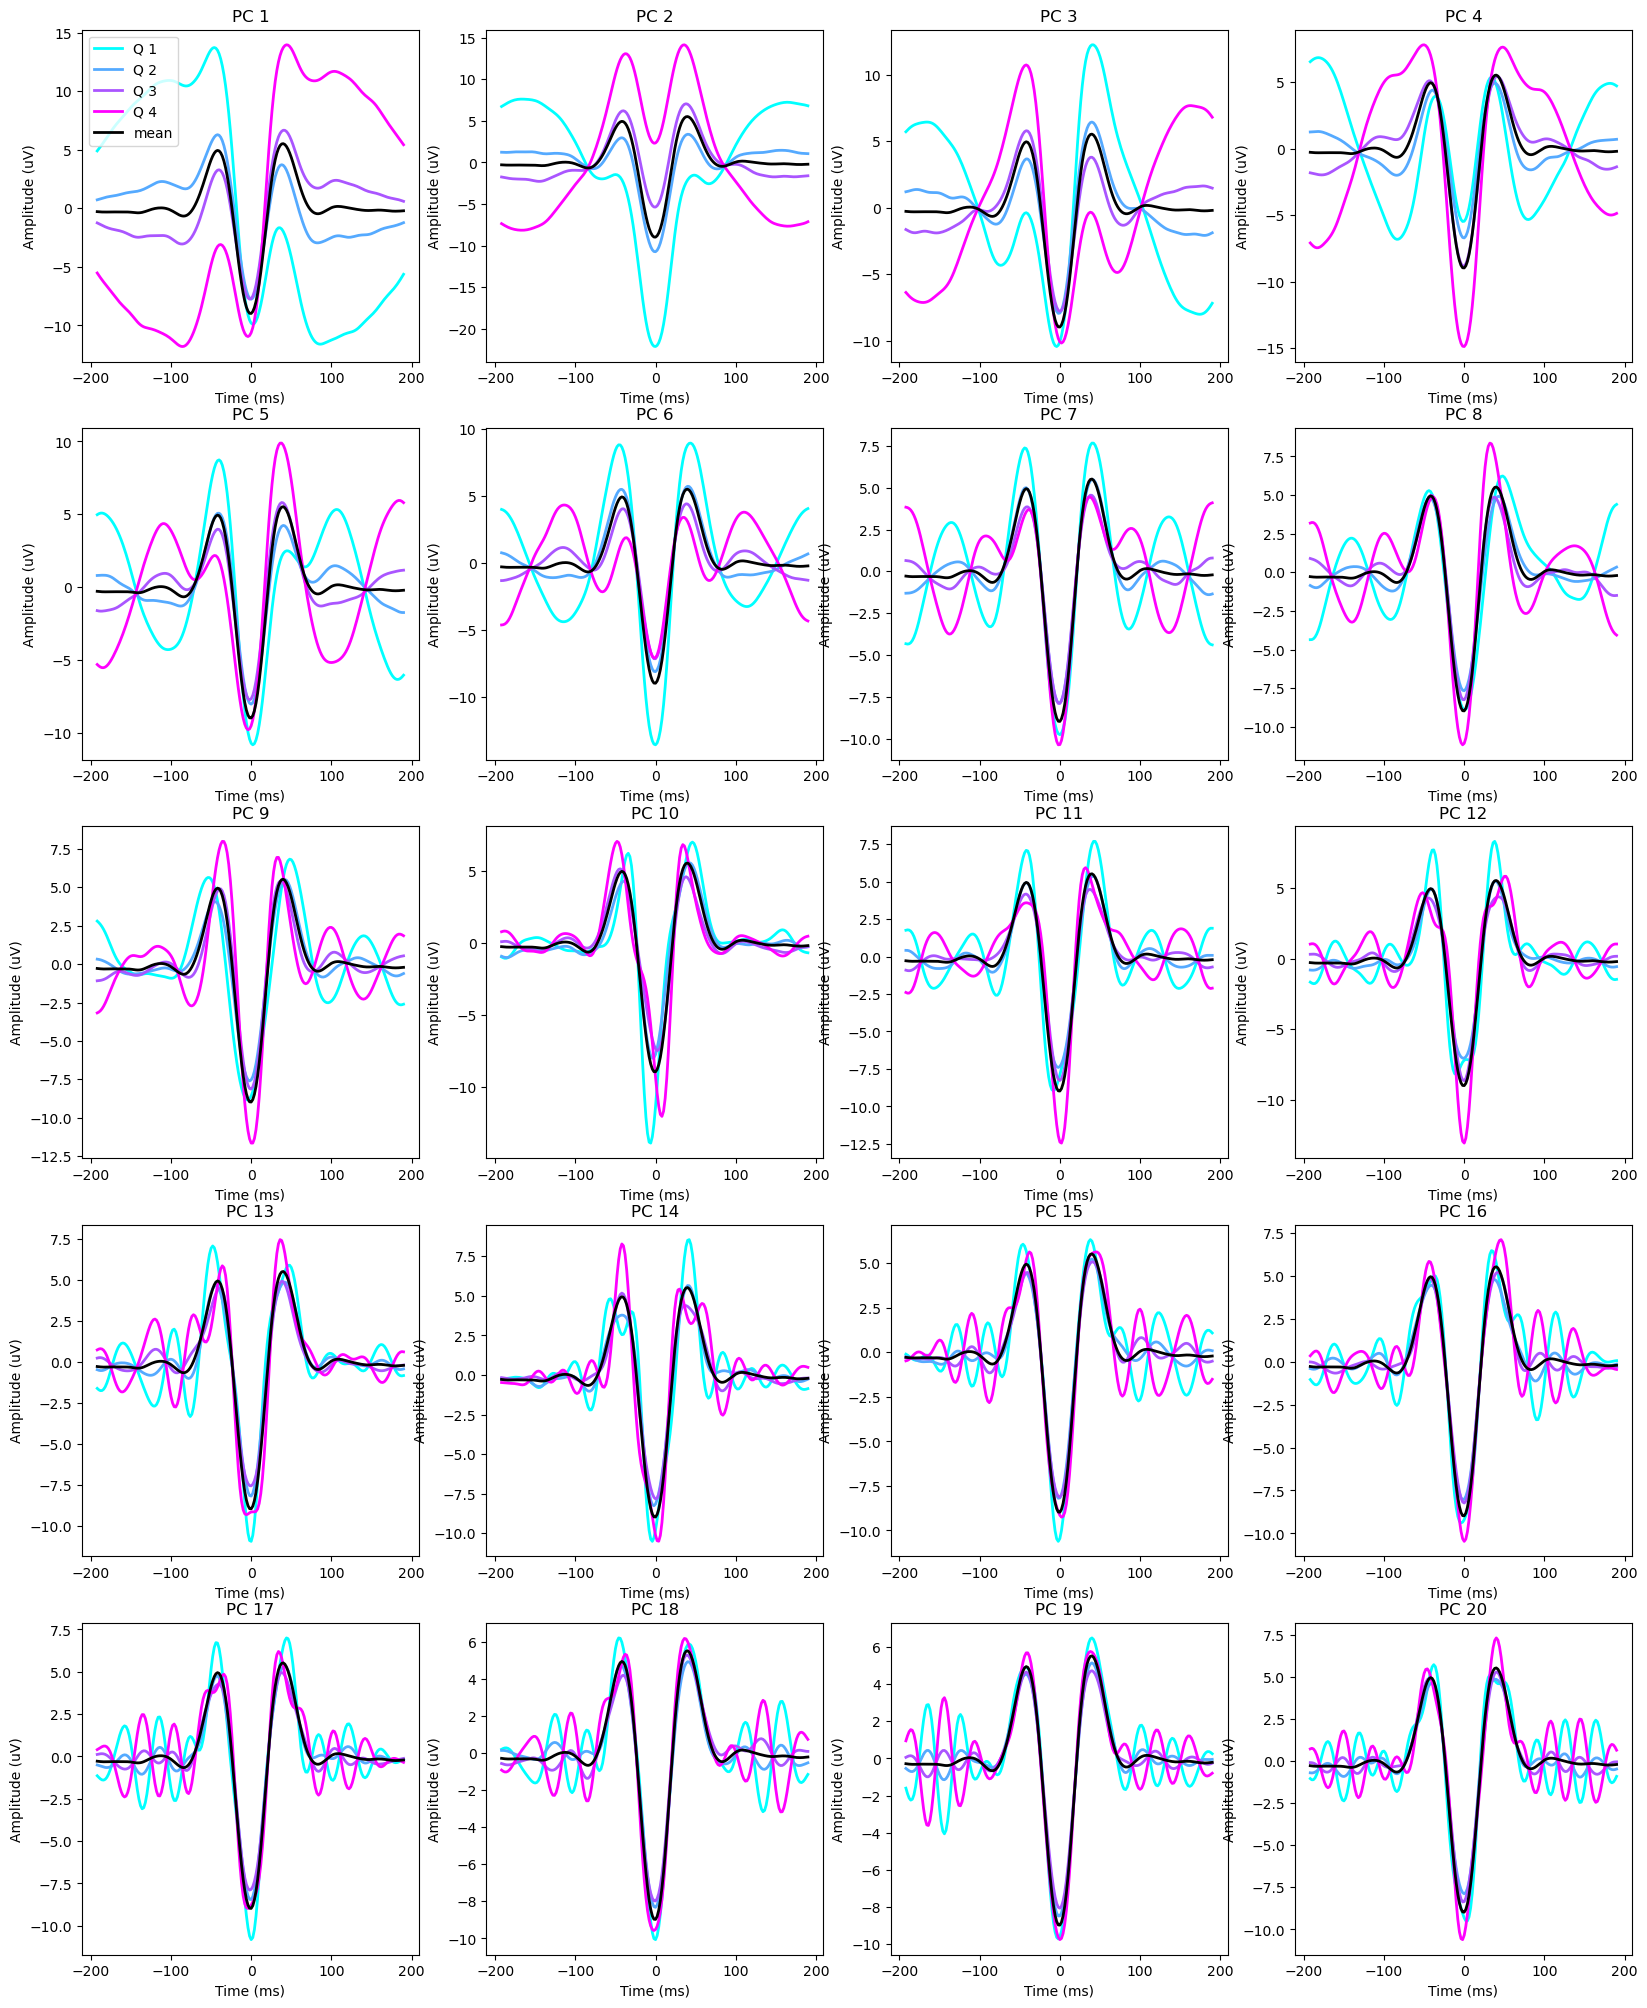

In [112]:
twelve_quartiles = np.linspace(0,100, num=5)
twelve_quartiles = list(zip(twelve_quartiles[:-1], twelve_quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(twelve_quartiles)))
mean_waveform_twelve = np.mean(twelve_waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(twelve_pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = twelve_pc_scores[:,pc_ix]
    q_maps = []
    for q_ix, (b,e) in enumerate(twelve_quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(twelve_waveforms[q_map], axis=0)
        ax[pc_ix].plot(twelve_waveform_times*1000, q_mean*1e6, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(twelve_waveform_times*1000, mean_waveform_twelve*1e6, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
    ax[pc_ix].set_xlabel('Time (ms)')
    ax[pc_ix].set_ylabel('Amplitude (uV)')
ax[0].legend(fontsize=10)
f.savefig('pc_plot_twelve_merged.png', dpi=300)

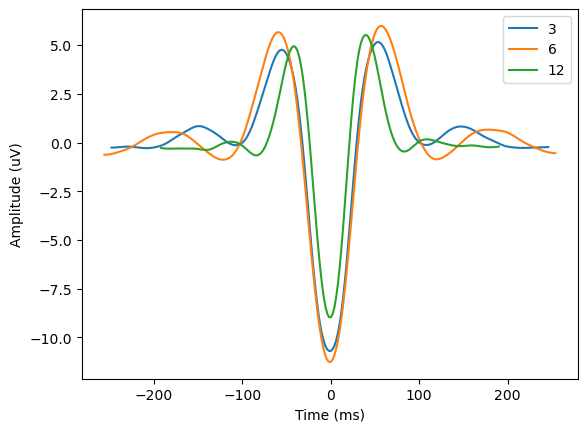

In [113]:
plt.plot(three_waveform_times*1000, np.mean(three_waveforms,axis=0)*1e6, label='3')
plt.plot(six_waveform_times*1000, np.mean(six_waveforms,axis=0)*1e6, label='6')
plt.plot(twelve_waveform_times*1000, np.mean(twelve_waveforms,axis=0)*1e6, label='12')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.savefig(f'/home/ldurieux/devmobeta_grasp/bursts_waveform.pdf', dpi=300, bbox_inches='tight')


In [114]:
med_3m=np.percentile(three_waveforms, 50, axis=0)
med_6m=np.percentile(six_waveforms, 50, axis=0)
med_12m=np.percentile(twelve_waveforms, 50, axis=0)
norm_3m=med_3m/np.max(med_3m)
norm_6m=med_6m/np.max(med_6m)
norm_12m=med_12m/np.max(med_12m)
alignment_3m=dtw(norm_3m, norm_12m, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_3m_idx=warp(alignment_3m,index_reference=False)
alignment_6m=dtw(norm_6m, norm_12m, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_6m_idx=warp(alignment_6m,index_reference=False)

aligned_3m_bursts=three_waveforms[:,aligned_3m_idx]
aligned_6m_bursts=six_waveforms[:,aligned_6m_idx]
aligned_12m_bursts=twelve_waveforms

aligned_c_bursts=np.vstack([aligned_3m_bursts,aligned_6m_bursts,aligned_12m_bursts])

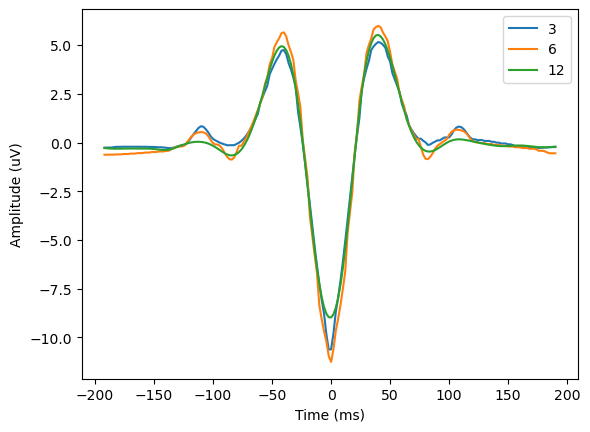

In [115]:
plt.plot(twelve_waveform_times*1000, np.mean(aligned_3m_bursts,axis=0)*1e6,label="3")
plt.plot(twelve_waveform_times*1000, np.mean(aligned_6m_bursts,axis=0)*1e6,label="6")
plt.plot(twelve_waveform_times*1000, np.mean(aligned_12m_bursts,axis=0)*1e6,label="12")
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
f.savefig('plot_waveform_aligned.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'/home/ldurieux/devmobeta_grasp/waveform_aligned.pdf', dpi=300, bbox_inches='tight')


In [116]:
burst_std_3m = RobustScaler().fit_transform(aligned_3m_bursts)
burst_std_6m = RobustScaler().fit_transform(aligned_6m_bursts)
burst_std_12m = RobustScaler().fit_transform(aligned_12m_bursts)

In [117]:
pca_3m = PCA(n_components=20)
pca_3m=pca_3m.fit(burst_std_3m)
pcs_3m_3m = pca_3m.transform(burst_std_3m)

pca_6m = PCA(n_components=20)
pca_6m=pca_6m.fit(burst_std_6m)
pcs_6m_6m = pca_6m.transform(burst_std_6m)

pca_12m = PCA(n_components=20)
pca_12m=pca_12m.fit(burst_std_12m)
pcs_12m_12m = pca_12m.transform(burst_std_12m)


In [118]:
# Initialisation des matrices de corrélation
corrmat_3m_6m = np.zeros((pca_3m.n_components, pca_6m.n_components))  # Corrélation 3m vs 6m
corrmat_3m_12m = np.zeros((pca_3m.n_components, pca_12m.n_components))  # Corrélation 3m vs 12m
corrmat_6m_12m = np.zeros((pca_6m.n_components, pca_12m.n_components))  # Corrélation 6m vs 12m

for i in range(pca_3m.n_components):
    for j in range(pca_6m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 3m et 6m
        res = spearmanr(pca_3m.components_[i, :], pca_6m.components_[j, :])
        corrmat_3m_6m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation
        
    for j in range(pca_12m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 3m et 12m
        res = spearmanr(pca_3m.components_[i, :], pca_12m.components_[j, :])
        corrmat_3m_12m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation

for i in range(pca_6m.n_components):
    for j in range(pca_12m.n_components):
        # Corrélation entre les vecteurs de composantes principales (PC) de 6m et 12m
        res = spearmanr(pca_6m.components_[i, :], pca_12m.components_[j, :])
        corrmat_6m_12m[i, j] = np.abs(res[0])  # Valeur absolue de la corrélation


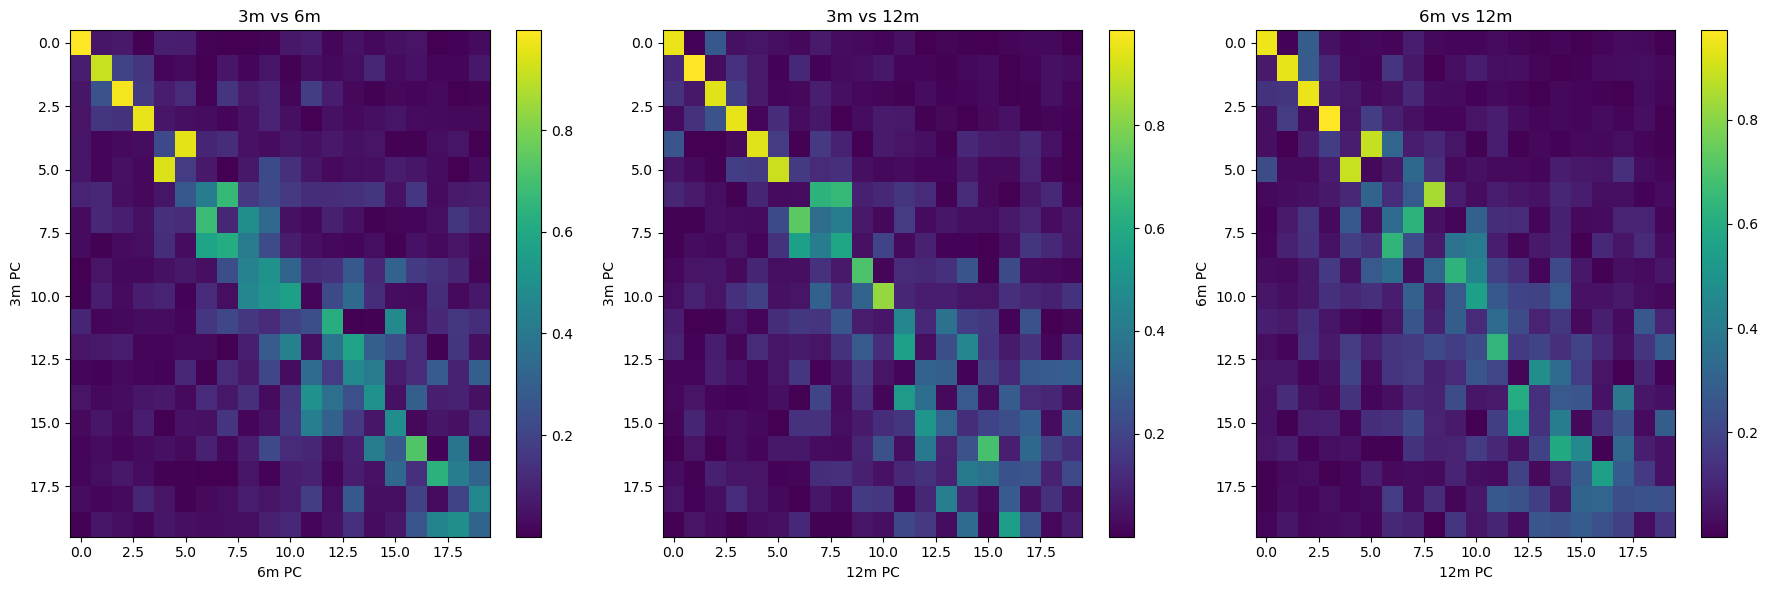

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 3m vs 6m
ax = axes[0]
cax = ax.imshow(corrmat_3m_6m[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs 6m')
ax.set_xlabel('6m PC')
ax.set_ylabel('3m PC')

# 3m vs 12m
ax = axes[1]
cax = ax.imshow(corrmat_3m_12m[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs 12m')
ax.set_xlabel('12m PC')
ax.set_ylabel('3m PC')

# 6m vs 12m
ax = axes[2]
cax = ax.imshow(corrmat_6m_12m[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('6m vs 12m')
ax.set_xlabel('12m PC')
ax.set_ylabel('6m PC')

plt.tight_layout()
plt.savefig(f'/home/ldurieux/devmobeta_grasp/PC_correlation.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [120]:
c_pca = PCA(n_components=20)

burst_std_c=np.vstack([burst_std_3m, burst_std_6m, burst_std_12m])
c_pca=c_pca.fit(burst_std_c)

pcs_3m = c_pca.transform(burst_std_3m)
pcs_6m = c_pca.transform(burst_std_6m)
pcs_12m = c_pca.transform(burst_std_12m)

pca_components_3m = pd.DataFrame(pcs_3m)
pca_components_6m = pd.DataFrame(pcs_6m)
pca_components_12m = pd.DataFrame(pcs_12m)

pcs_c=np.vstack([pcs_3m,pcs_6m,pcs_12m])

In [121]:
cum_var_exp=np.cumsum(c_pca.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_c=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_c=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_c+1,cum_var_exp[idx_c]*100))

5 components explain 81.64757357821297% of variance


In [122]:
cum_var_exp=np.cumsum(pca_3m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_3m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_3m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_3m+1,cum_var_exp[idx_3m]*100))

4 components explain 81.57299203048298% of variance


In [123]:
cum_var_exp=np.cumsum(pca_6m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_6m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_6m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_6m+1,cum_var_exp[idx_6m]*100))

5 components explain 80.83598637108007% of variance


In [124]:
cum_var_exp=np.cumsum(pca_12m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx_12m=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx_12m=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx_12m+1,cum_var_exp[idx_12m]*100))

5 components explain 81.35678223275413% of variance


In [125]:
# Initialisation des matrices de corrélation
corrmat_3m_c = np.zeros((pca_3m.n_components, c_pca.n_components))  
corrmat_6m_c = np.zeros((pca_6m.n_components, c_pca.n_components))  
corrmat_12m_c = np.zeros((pca_12m.n_components, c_pca.n_components))  

# Corrélation entre les PC locales et les PC globales
for i in range(pca_3m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_3m.components_[i, :], c_pca.components_[j, :])  
        corrmat_3m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 3m et PCA globale

for i in range(pca_6m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_6m.components_[i, :], c_pca.components_[j, :])  
        corrmat_6m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 6m et PCA globale

for i in range(pca_12m.n_components):
    for j in range(c_pca.n_components):
        res = spearmanr(pca_12m.components_[i, :], c_pca.components_[j, :])  
        corrmat_12m_c[i, j] = np.abs(res[0])  # Corrélation absolue entre 12m et PCA globale



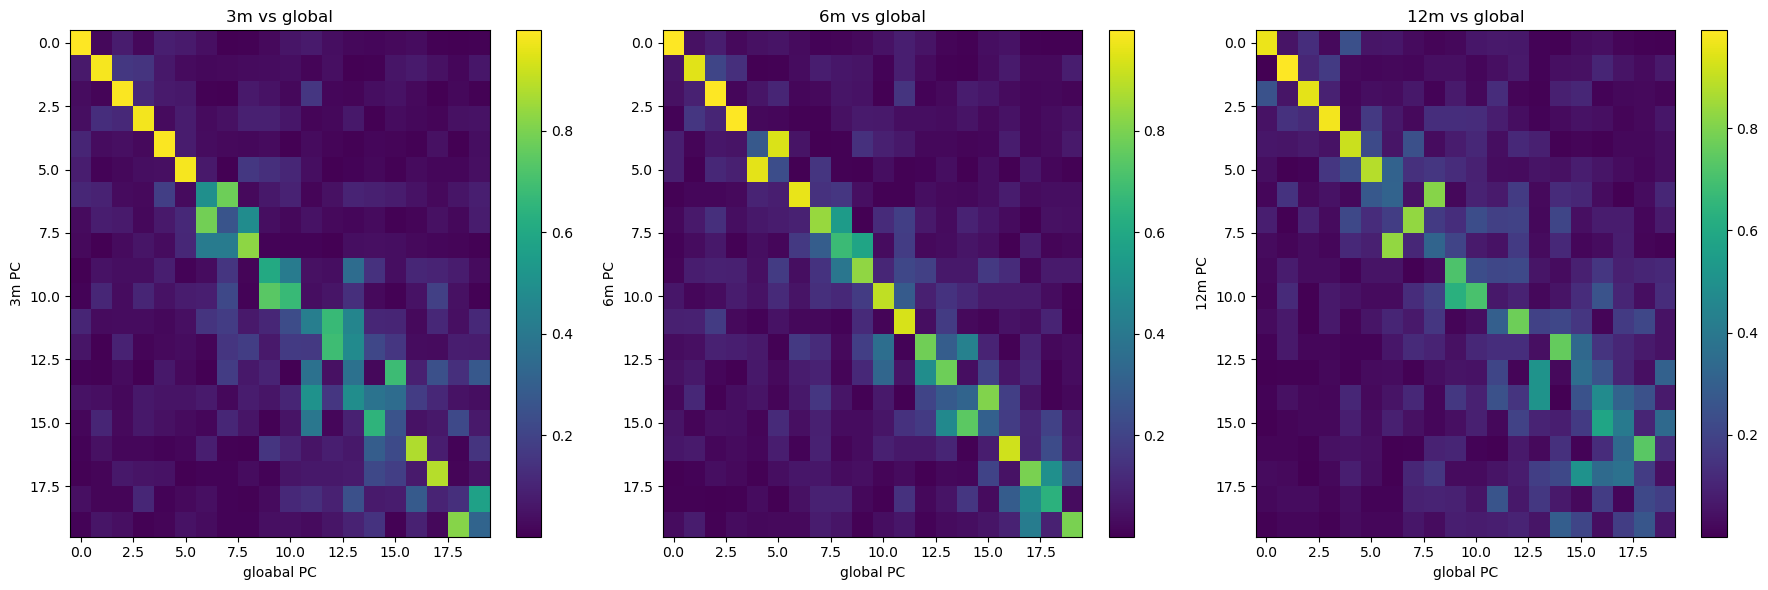

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 3m vs 6m
ax = axes[0]
cax = ax.imshow(corrmat_3m_c[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('3m vs global')
ax.set_xlabel('gloabal PC')
ax.set_ylabel('3m PC')

# 3m vs 12m
ax = axes[1]
cax = ax.imshow(corrmat_6m_c[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('6m vs global')
ax.set_xlabel('global PC')
ax.set_ylabel('6m PC')

# 6m vs 12m
ax = axes[2]
cax = ax.imshow(corrmat_12m_c[:20,:20], aspect='auto', origin='upper', cmap='viridis')
fig.colorbar(cax, ax=ax)
ax.set_title('12m vs global')
ax.set_xlabel('global PC')
ax.set_ylabel('12m PC')

plt.tight_layout()
plt.show()

In [127]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array


def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = len(np.where(results > threshold)[0])
    return PCS_to_analyse

In [128]:
pcs_to_analyze_3m=get_num_components(three_waveforms, idx_3m+1)
print('C: {}'.format(pcs_to_analyze_3m))

C: 4


In [129]:
pcs_to_analyze_6m=get_num_components(six_waveforms, idx_6m+1)
print('C:{}'. format(pcs_to_analyze_6m))

C:5


In [130]:
pcs_to_analyze_12m=get_num_components(twelve_waveforms, idx_12m+1)
print('C:{}'. format(pcs_to_analyze_12m))

C:5


In [131]:
pcs_to_analyze_c=get_num_components(aligned_c_bursts,idx_c)
print('C:{}'.format(pcs_to_analyze_c))

C:4


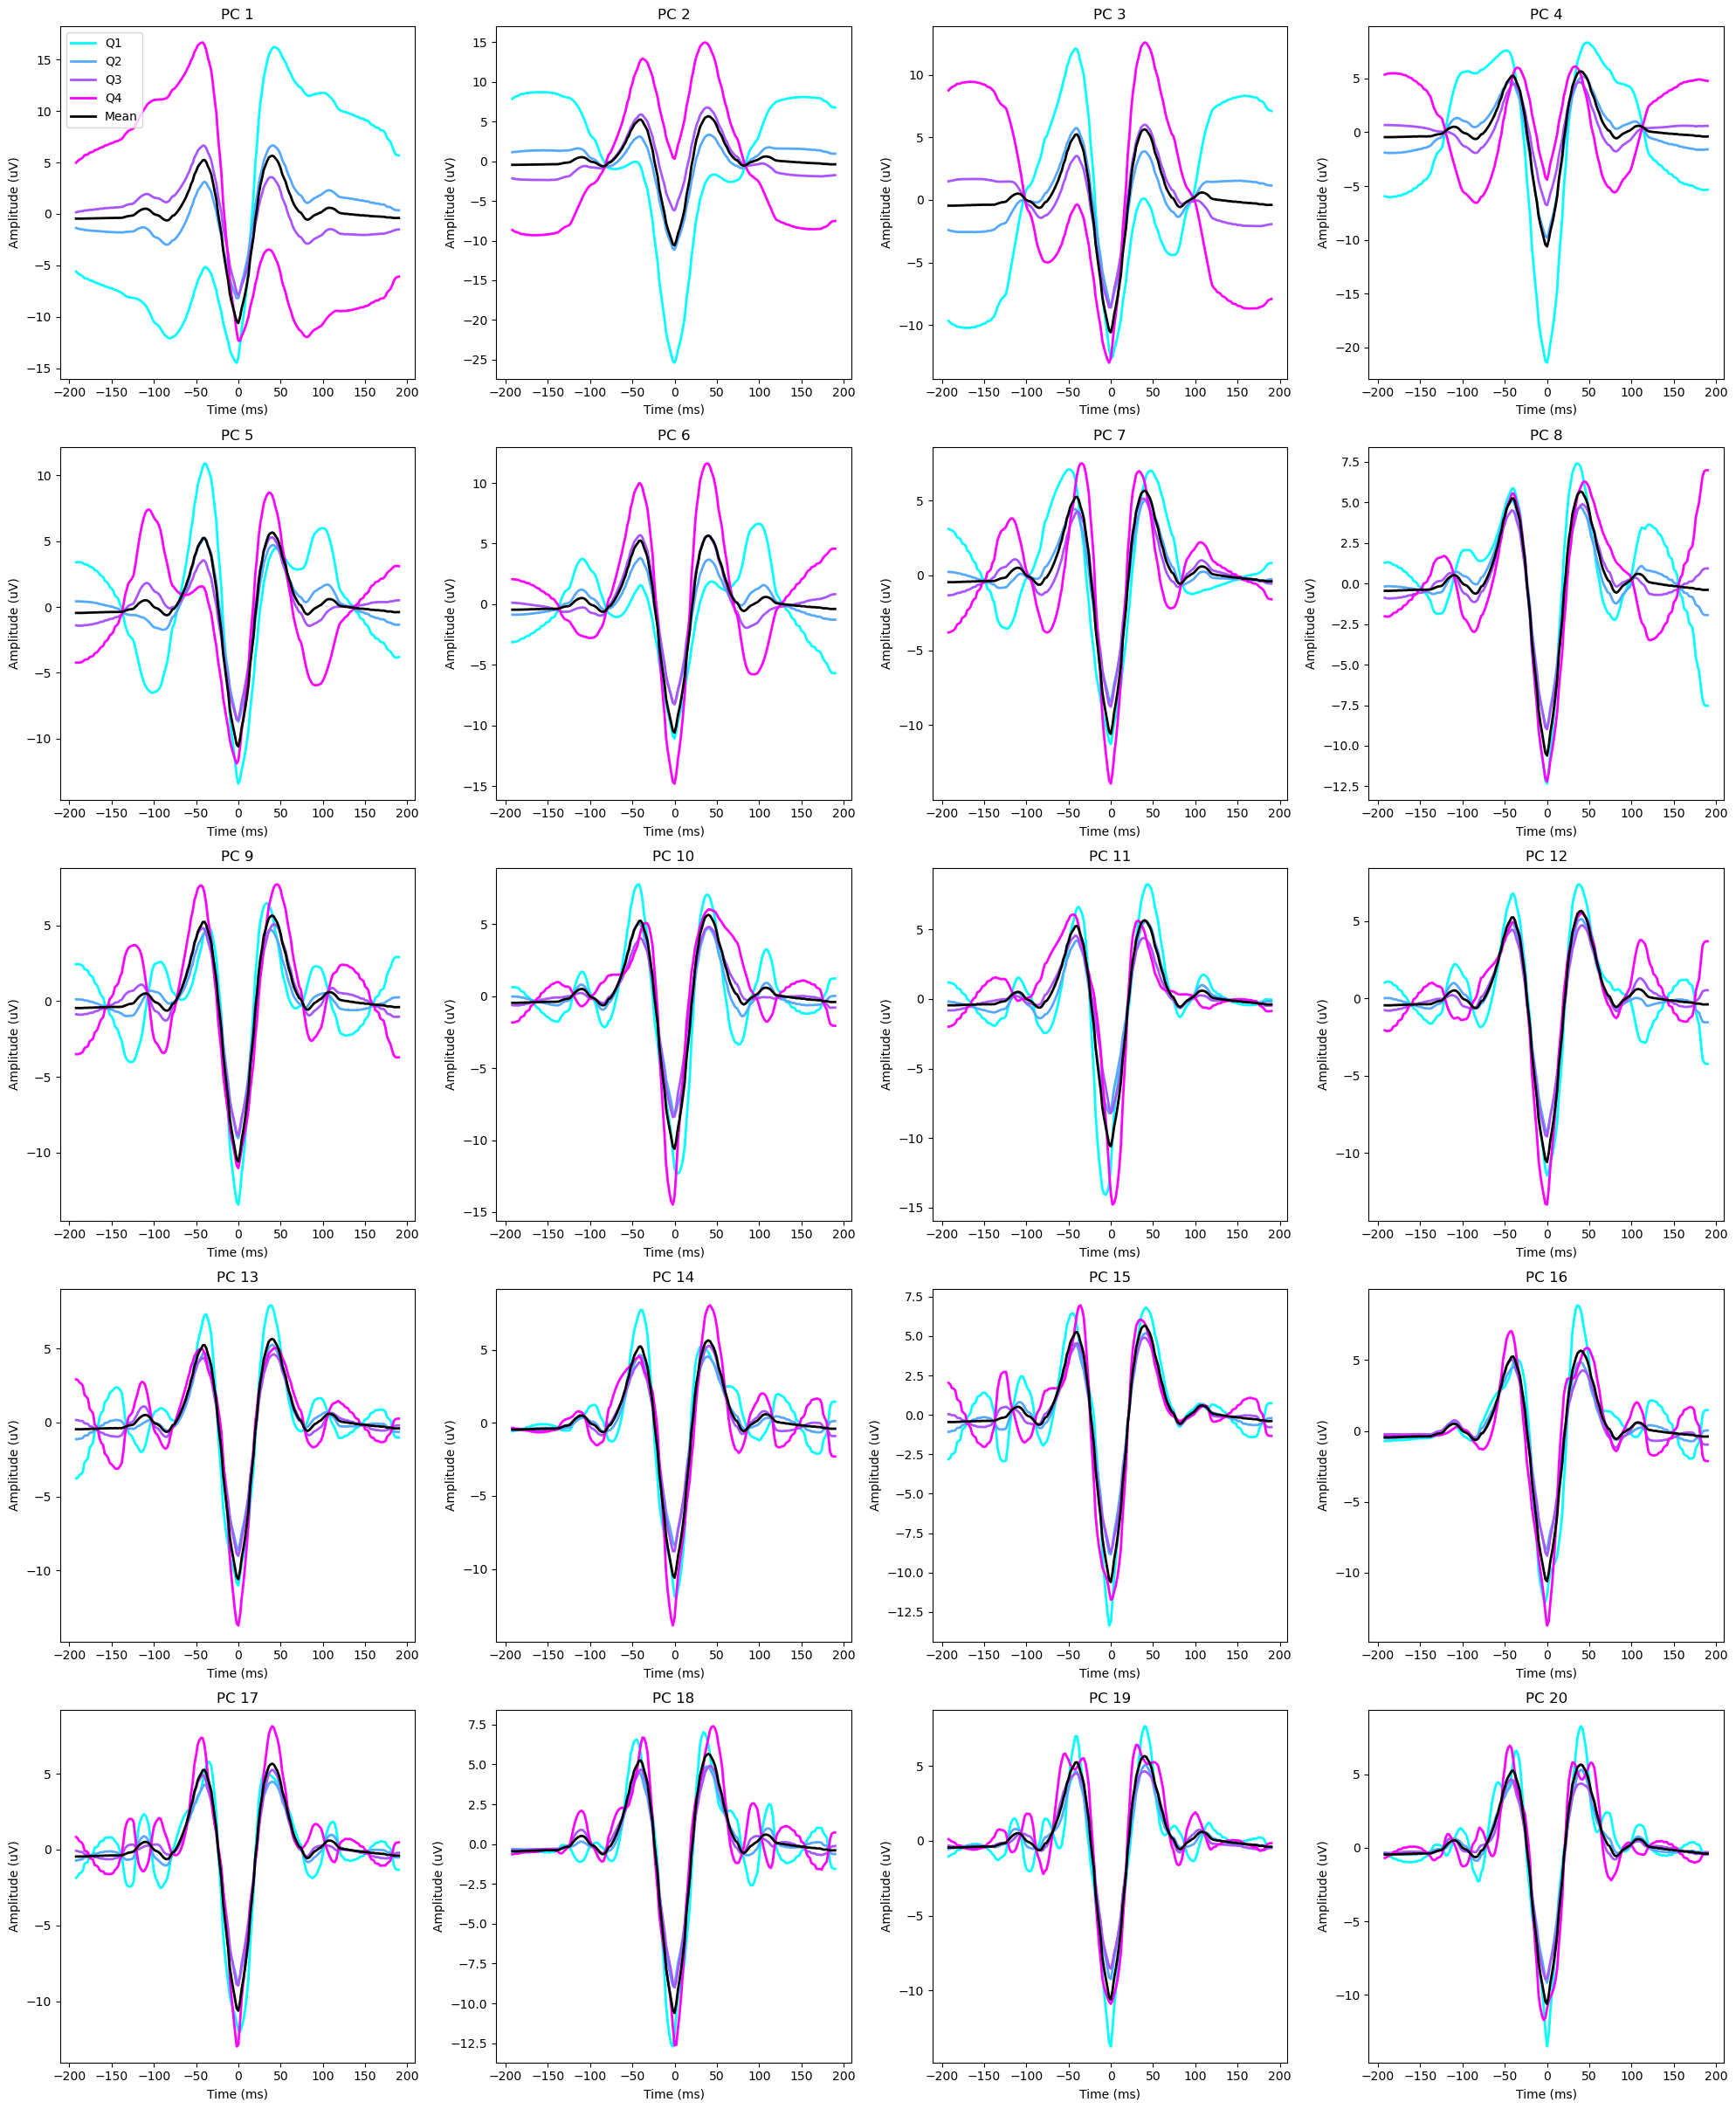

In [132]:
c_pca = PCA(n_components=20) 
c_pca.fit(aligned_c_bursts)

pcs_c = c_pca.transform(aligned_c_bursts)

pc_labels = ["PC_{}".format(i + 1) for i in range(pcs_c.shape[1])]

quartiles = np.linspace(0, 100, num=5)
quartile_ranges = list(zip(quartiles[:-1], quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0, 1, num=len(quartile_ranges)))

mean_waveform = np.mean(aligned_c_bursts, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20, 25))
ax = ax.flatten()

# Tracer les formes d'onde pour chaque PC
for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " "))

    scores = pcs_c[:, pc_ix]

    for q_ix, (b, e) in enumerate(quartile_ranges):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e))
        q_mean = np.mean(aligned_c_bursts[q_map], axis=0)
        ax[pc_ix].plot(twelve_waveform_times*1000, q_mean *1e6, lw=2, c=col_range[q_ix], label="Q{}".format(q_ix + 1))

    ax[pc_ix].plot(twelve_waveform_times*1000, mean_waveform *1e6, lw=2, c="black", label="Mean")
    ax[pc_ix].set_xlabel('Time (ms)')
    ax[pc_ix].set_ylabel('Amplitude (uV)')

ax[0].legend(fontsize=10)
f.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'/home/ldurieux/devmobeta_grasp/PC_merged.pdf', dpi=300, bbox_inches='tight')


In [67]:
import numpy as np
from joblib import Parallel, delayed

def permutation_test(data1, data2, n_permutations=10000, n_jobs=-1):
    obs_diff = np.nanmean(data1) - np.nanmean(data2)
    combined_data = np.concatenate([data1, data2])
    n1 = len(data1)

    def perm():
        shuffled = np.random.permutation(combined_data)
        return np.nanmean(shuffled[:n1]) - np.nanmean(shuffled[n1:])

    perm_diffs = Parallel(n_jobs=n_jobs)(delayed(perm)() for _ in range(n_permutations))
    perm_diffs = np.array(perm_diffs)
    p_value = np.nanmean(np.abs(perm_diffs) >= np.abs(obs_diff))
    return obs_diff, p_value


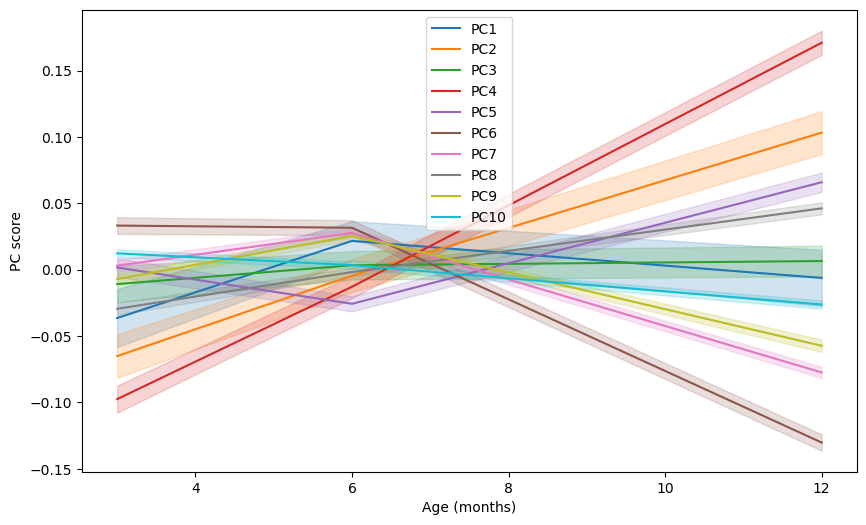

In [68]:
def annotate_sig(p_value, x1, x2, y_max, color, ax):
    """Annotation de significativité sur le graphique en utilisant des étoiles et barres fines"""
    if p_value < 0.05:
        ax.plot([x1, x2], [y_max, y_max], color=color, lw=1)  
    if p_value < 0.001:
        ax.text((x1 + x2) / 2, y_max + 0.005, "***", ha='center', va='bottom', color=color, fontsize=12)
    elif p_value < 0.01:
        ax.text((x1 + x2) / 2, y_max + 0.005, "**", ha='center', va='bottom', color=color, fontsize=12)
    elif p_value < 0.05:
        ax.text((x1 + x2) / 2, y_max + 0.005, "*", ha='center', va='bottom', color=color, fontsize=12)

fig, ax = plt.subplots(figsize=(10, 6))
for pc_idx in range(10):
    diff_3m_6m, p_3m_6m = permutation_test(pcs_3m[:, pc_idx], pcs_6m[:, pc_idx])
    diff_6m_12m, p_6m_12m = permutation_test(pcs_6m[:, pc_idx], pcs_12m[:, pc_idx])
    diff_3m_12m, p_3m_12m = permutation_test(pcs_3m[:, pc_idx], pcs_12m[:, pc_idx])

    scores = [np.mean(pcs_3m[:, pc_idx]), np.mean(pcs_6m[:, pc_idx]), np.mean(pcs_12m[:, pc_idx])]
    ses = [np.std(pcs_3m[:, pc_idx]) / np.sqrt(pcs_3m.shape[0]),
           np.std(pcs_6m[:, pc_idx]) / np.sqrt(pcs_6m.shape[0]),
           np.std(pcs_12m[:, pc_idx]) / np.sqrt(pcs_12m.shape[0])]
    
    line, = ax.plot([3, 6, 12], scores, label=f'PC{pc_idx+1}')
    ax.fill_between([3, 6, 12], np.array(scores) - np.array(ses) * 0.5,
                    np.array(scores) + np.array(ses) * 0.5, alpha=0.2, color=line.get_color())
    
    y_max = max(np.array(scores) + np.array(ses)) * 1.2  
    
    max_score = max(scores)
    min_score = min(scores)
    
    #star_y_position = y_max
    #if star_y_position > max_score + 0.2:
     #   star_y_position = max_score + 0.05  # Ajuster pour que l'étoile reste dans les limites
    
    #annotate_sig(p_3m_6m, 3, 6, star_y_position, color=line.get_color(), ax=ax)  # 3m vs 6m
    #annotate_sig(p_6m_12m, 6, 12, star_y_position, color=line.get_color(), ax=ax)  # 6m vs 12m
    #annotate_sig(p_3m_12m, 3, 12, star_y_position, color=line.get_color(), ax=ax)  # 3m vs 12m

ax.legend()
ax.set_xlabel('Age (months)')
ax.set_ylabel('PC score')

#plt.savefig('/home/ldurieux/devmobeta_grasp/PC_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [133]:
with open('merged_bursts_three.json', 'r') as f:
    burst_data = json.load(f)

csv_rows = []
pc_labels = [f'PC{i+1}' for i in range(20)]  # 6 first PC
burst_idx = 0  

for ch_data in burst_data:
    subject = ch_data['subject']
    epoch = ch_data['epoch']
    age = 'three'  
    system = ch_data.get('system', 'unknown') 
    cluster = ch_data.get('cluster', 'unknown')
    n_bursts = len(ch_data['bursts']['trial'])

    for i in range(n_bursts):
        row = {
            'subject': subject,
            'age': age,
            'epoch': epoch,
            'system': system, 
            'cluster': cluster,
            'trial': ch_data['bursts']['trial'][i],
            'time': ch_data['bursts']['peak_time'][i],
        }

        for j, pc in enumerate(pc_labels):
            row[pc] = three_pc_scores[burst_idx, j]

        burst_idx += 1
        csv_rows.append(row)

csv_columns = ['subject', 'age', 'epoch', 'system', 'trial', 'time','cluster'] + pc_labels

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_three.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_rows)


In [134]:
with open('merged_bursts_six.json', 'r') as f:
    burst_data = json.load(f)

csv_rows = []
pc_labels = [f'PC{i+1}' for i in range(20)]  # 20 PC
burst_idx = 0  

for ch_data in burst_data:
    subject = ch_data['subject']
    epoch = ch_data['epoch']
    age = 'six'  
    system = ch_data.get('system', 'unknown') 
    cluster = ch_data.get('cluster', 'unknown') 
    n_bursts = len(ch_data['bursts']['trial'])

    for i in range(n_bursts):
        row = {
            'subject': subject,
            'age': age,
            'epoch': epoch,
            'system': system,  
            'cluster': cluster,
            'trial': ch_data['bursts']['trial'][i],
            'time': ch_data['bursts']['peak_time'][i],
        }

        for j, pc in enumerate(pc_labels):
            row[pc] = six_pc_scores[burst_idx, j]

        burst_idx += 1
        csv_rows.append(row)

# ajout de 'system' dans la liste des colonnes :
csv_columns = ['subject', 'age', 'epoch', 'system', 'trial', 'time','cluster'] + pc_labels

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_six.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_rows)


In [135]:
with open('merged_bursts_twelve.json', 'r') as f:
    burst_data = json.load(f)

csv_rows = []
pc_labels = [f'PC{i+1}' for i in range(20)]  # 20 first PC
burst_idx = 0  

for ch_data in burst_data:
    subject = ch_data['subject']
    epoch = ch_data['epoch']
    age = 'twelve'  
    system = ch_data.get('system', 'unknown') 
    cluster = ch_data.get('cluster','unknown')
    n_bursts = len(ch_data['bursts']['trial'])

    for i in range(n_bursts):
        row = {
            'subject': subject,
            'age': age,
            'epoch': epoch,
            'system': system, 
            'cluster': cluster,
            'trial': ch_data['bursts']['trial'][i],
            'time': ch_data['bursts']['peak_time'][i],
        }

        for j, pc in enumerate(pc_labels):
            row[pc] = twelve_pc_scores[burst_idx, j]

        burst_idx += 1
        csv_rows.append(row)

#  ajout de 'system' dans la liste des colonnes :
csv_columns = ['subject', 'age', 'epoch', 'system', 'trial', 'time','cluster'] + pc_labels

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_twelve.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_rows)


In [136]:
print(burst_data[0].keys())

dict_keys(['subject', 'epoch', 'session', 'channel', 'system', 'cluster', 'bursts', 'beta_power'])


In [137]:
subjects_3 = set()

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_three.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        subjects_3.add(row['subject'])

print(f"Nombre de sujets : {len(subjects_3)}")


subjects_6 = set()

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_six.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        subjects_6.add(row['subject'])

print(f"Nombre de sujets : {len(subjects_6)}")


subjects_12 = set()

with open('/home/ldurieux/devmobeta_grasp/bursts_with_pc_twelve.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        subjects_12.add(row['subject'])

print(f"Nombre de sujets : {len(subjects_12)}")

Nombre de sujets : 48
Nombre de sujets : 43
Nombre de sujets : 21


In [138]:
subject = set()
for ch_bursts in burst_three:
    subject.add(ch_bursts['subject']) 

n_subjects = len(subject)
print(f"Nombre de sujets : {n_subjects}")

subject = set()
for ch_bursts in burst_six:
    subject.add(ch_bursts['subject'])

n_subjects = len(subject)
print(f"Nombre de sujets : {n_subjects}")

subject = set()
for ch_bursts in burst_twelve:
    subject.add(ch_bursts['subject'])

n_subjects = len(subject)
print(f"Nombre de sujets : {n_subjects}")

Nombre de sujets : 49
Nombre de sujets : 45
Nombre de sujets : 22


In [139]:
# Affiche les sujets du CSV
print(sorted(subjects_12))

# Affiche les sujets de burst_twelve
print(sorted({ch['subject'].strip() for ch in burst_twelve}))


['sub-203', 'sub-204', 'sub-207', 'sub-208', 'sub-209', 'sub-218', 'sub-238', 'sub-242', 'sub-245', 'sub-246', 'sub-248', 'sub-252', 'sub-253', 'sub-254', 'sub-261', 'sub-264', 'sub-265', 'sub-270', 'sub-273', 'sub-275', 'sub-278']
['sub-201', 'sub-203', 'sub-204', 'sub-207', 'sub-208', 'sub-209', 'sub-218', 'sub-238', 'sub-242', 'sub-245', 'sub-246', 'sub-248', 'sub-252', 'sub-253', 'sub-254', 'sub-261', 'sub-264', 'sub-265', 'sub-270', 'sub-273', 'sub-275', 'sub-278']


In [140]:
# Affiche les sujets du CSV
print(sorted(subjects_6))

# Affiche les sujets de burst_three
print(sorted({ch['subject'].strip() for ch in burst_six}))

['sub-201', 'sub-203', 'sub-204', 'sub-205', 'sub-206', 'sub-207', 'sub-208', 'sub-209', 'sub-210', 'sub-211', 'sub-212', 'sub-213', 'sub-214', 'sub-215', 'sub-216', 'sub-217', 'sub-218', 'sub-219', 'sub-220', 'sub-221', 'sub-222', 'sub-223', 'sub-224', 'sub-225', 'sub-226', 'sub-227', 'sub-230', 'sub-232', 'sub-239', 'sub-240', 'sub-254', 'sub-260', 'sub-262', 'sub-265', 'sub-266', 'sub-267', 'sub-268', 'sub-269', 'sub-270', 'sub-271', 'sub-274', 'sub-278', 'sub-280']
['sub-201', 'sub-203', 'sub-204', 'sub-205', 'sub-206', 'sub-207', 'sub-208', 'sub-209', 'sub-210', 'sub-211', 'sub-212', 'sub-213', 'sub-214', 'sub-215', 'sub-216', 'sub-217', 'sub-218', 'sub-219', 'sub-220', 'sub-221', 'sub-222', 'sub-223', 'sub-224', 'sub-225', 'sub-226', 'sub-227', 'sub-230', 'sub-232', 'sub-239', 'sub-240', 'sub-250', 'sub-254', 'sub-260', 'sub-262', 'sub-265', 'sub-266', 'sub-267', 'sub-268', 'sub-269', 'sub-270', 'sub-271', 'sub-273', 'sub-274', 'sub-278', 'sub-280']


In [141]:
# 265 et 256 age three ; 238  age twelve

In [142]:
from collections import defaultdict

with open('merged_bursts_three.json', 'r') as f:
    burst_data = json.load(f)

bursts_per_subject = defaultdict(int)
total_json_bursts = 0

for ch_data in burst_data:
    subject = ch_data['subject']
    n_bursts = len(ch_data['bursts']['trial'])
    bursts_per_subject[subject] += n_bursts
    total_json_bursts += n_bursts

print("Nombre de bursts par sujet dans JSON")
for subj, count in bursts_per_subject.items():
    print(f"{subj} : {count}")
print(f"\nTotal bursts dans JSON : {total_json_bursts}")

# Charger les scores PCA 
print("\nChargement de three_pc_scores...")
print("three_pc_scores.shape :", three_pc_scores.shape)
print(f"Total bursts dans three_pc_scores : {three_pc_scores.shape[0]}")

# 4. Comparaison globale
if three_pc_scores.shape[0] != total_json_bursts:
    print("\n ATTENTION : Le nombre de bursts dans les scores PCA ne correspond pas au JSON.")
    missing = total_json_bursts - three_pc_scores.shape[0]
    if missing > 0:
        print(f"Il manque {missing} bursts dans three_pc_scores.")
    else:
        print(f"Il y a {abs(missing)} bursts en trop dans three_pc_scores.")
else:
    print("\n OK : Nombre de bursts cohérent entre JSON et PCA.")

#  Pour retrouver à quel moment ça diverge
burst_idx = 0
error_found = False
for ch_data in burst_data:
    subject = ch_data['subject']
    n_bursts = len(ch_data['bursts']['trial'])
    
    for i in range(n_bursts):
        if burst_idx >= three_pc_scores.shape[0]:
            print(f"\n Problème détecté : le burst {i+1}/{n_bursts} du sujet {subject} dépasse la taille de three_pc_scores")
            error_found = True
            break
        burst_idx += 1
    if error_found:
        break


Nombre de bursts par sujet dans JSON
sub-253 : 894
sub-254 : 175
sub-255 : 25
sub-256 : 276
sub-258 : 911
sub-260 : 868
sub-261 : 782
sub-262 : 91
sub-264 : 1297
sub-265 : 429
sub-266 : 477
sub-267 : 933
sub-269 : 105
sub-274 : 563
sub-277 : 292
sub-278 : 0
sub-201 : 1303
sub-203 : 1189
sub-205 : 1161
sub-206 : 274
sub-207 : 2904
sub-208 : 1227
sub-209 : 1191
sub-210 : 1502
sub-211 : 1445
sub-212 : 1749
sub-213 : 1479
sub-215 : 988
sub-216 : 1379
sub-217 : 380
sub-218 : 1069
sub-219 : 1268
sub-220 : 871
sub-221 : 642
sub-223 : 3060
sub-224 : 796
sub-225 : 945
sub-226 : 2135
sub-229 : 1746
sub-230 : 1398
sub-231 : 880
sub-232 : 2634
sub-233 : 218
sub-234 : 482
sub-235 : 121
sub-236 : 359
sub-237 : 100
sub-238 : 1082
sub-241 : 970

Total bursts dans JSON : 47065

Chargement de three_pc_scores...
three_pc_scores.shape : (47065, 20)
Total bursts dans three_pc_scores : 47065

 OK : Nombre de bursts cohérent entre JSON et PCA.


In [143]:
import json
import numpy as np
from collections import defaultdict

age = 'twelve' 
json_file = f'merged_bursts_{age}.json'

with open(json_file, 'r') as f:
    burst_data = json.load(f)

bursts_per_subject = defaultdict(int)
total_json_bursts = 0

for ch_data in burst_data:
    subject = ch_data['subject']
    n_bursts = len(ch_data['bursts']['trial'])
    bursts_per_subject[subject] += n_bursts
    total_json_bursts += n_bursts

print(f" Nombre de bursts par sujet pour l'âge {age} ")
for subj, count in bursts_per_subject.items():
    print(f"{subj} : {count}")
print(f"\nTotal bursts pour l'âge {age} : {total_json_bursts}")

# Comparaison avec les scores PCA
print("\nChargement de twelve_pc_scores...")
print("twelve_pc_scores.shape :", twelve_pc_scores.shape)
print(f"Total bursts dans twelve_pc_scores : {twelve_pc_scores.shape[0]}")

if twelve_pc_scores.shape[0] != total_json_bursts:
    print("\n?? ATTENTION : Le nombre de bursts dans les scores PCA ne correspond pas au JSON.")
    missing = total_json_bursts - twelve_pc_scores.shape[0]
    if missing > 0:
        print(f"Il manque {missing} bursts dans twelve_pc_scores.")
    else:
        print(f"Il y a {abs(missing)} bursts en trop dans twelve_pc_scores.")
else:
    print("\n? OK : Nombre de bursts cohérent entre JSON et PCA.")


 Nombre de bursts par sujet pour l'âge twelve 
sub-238 : 435
sub-242 : 389
sub-245 : 177
sub-246 : 121
sub-248 : 2086
sub-252 : 1849
sub-253 : 1792
sub-254 : 1912
sub-261 : 368
sub-264 : 421
sub-265 : 278
sub-270 : 1761
sub-273 : 1518
sub-275 : 2168
sub-278 : 429
sub-201 : 0
sub-203 : 118
sub-204 : 1179
sub-207 : 8014
sub-208 : 6876
sub-209 : 3142
sub-218 : 695

Total bursts pour l'âge twelve : 35728

Chargement de twelve_pc_scores...
twelve_pc_scores.shape : (35728, 20)
Total bursts dans twelve_pc_scores : 35728

? OK : Nombre de bursts cohérent entre JSON et PCA.


In [144]:
age = 'six'  
json_file = f'merged_bursts_{age}.json'

with open(json_file, 'r') as f:
    burst_data = json.load(f)

# Compter le nombre de bursts par sujet
bursts_per_subject = defaultdict(int)
total_json_bursts = 0

for ch_data in burst_data:
    subject = ch_data['subject']
    n_bursts = len(ch_data['bursts']['trial'])
    bursts_per_subject[subject] += n_bursts
    total_json_bursts += n_bursts

print(f"=== Nombre de bursts par sujet pour l'âge {age} ===")
for subj, count in bursts_per_subject.items():
    print(f"{subj} : {count}")
print(f"\nTotal bursts pour l'âge {age} : {total_json_bursts}")

# Comparaison avec les scores PCA
print("\nChargement de six_pc_scores...")
print("six_pc_scores.shape :", six_pc_scores.shape)
print(f"Total bursts dans six_pc_scores : {six_pc_scores.shape[0]}")

if six_pc_scores.shape[0] != total_json_bursts:
    print("\ATTENTION : Le nombre de bursts dans les scores PCA ne correspond pas au JSON.")
    missing = total_json_bursts - six_pc_scores.shape[0]
    if missing > 0:
        print(f"Il manque {missing} bursts dans six_pc_scores.")
    else:
        print(f"Il y a {abs(missing)} bursts en trop dans six_pc_scores.")
else:
    print("\n? OK : Nombre de bursts cohérent entre JSON et PCA.")

<>:28: SyntaxWarning: invalid escape sequence '\A'
<>:28: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_64252/1886440664.py:28: SyntaxWarning: invalid escape sequence '\A'
  print("\ATTENTION : Le nombre de bursts dans les scores PCA ne correspond pas au JSON.")


=== Nombre de bursts par sujet pour l'âge six ===
sub-250 : 0
sub-254 : 510
sub-260 : 142
sub-262 : 2496
sub-265 : 922
sub-266 : 1453
sub-267 : 672
sub-268 : 806
sub-269 : 1255
sub-270 : 433
sub-271 : 881
sub-273 : 0
sub-274 : 1330
sub-278 : 185
sub-280 : 766
sub-201 : 643
sub-203 : 2974
sub-204 : 1842
sub-205 : 1964
sub-206 : 2190
sub-207 : 1272
sub-208 : 1497
sub-209 : 905
sub-210 : 1949
sub-211 : 5388
sub-212 : 6015
sub-213 : 3031
sub-214 : 1727
sub-215 : 131
sub-216 : 295
sub-217 : 3532
sub-218 : 1389
sub-219 : 2651
sub-220 : 2023
sub-221 : 5430
sub-222 : 4109
sub-223 : 4986
sub-224 : 7265
sub-225 : 3819
sub-226 : 1380
sub-227 : 588
sub-230 : 3098
sub-232 : 2754
sub-239 : 1784
sub-240 : 358

Total bursts pour l'âge six : 88840

Chargement de six_pc_scores...
six_pc_scores.shape : (88840, 20)
Total bursts dans six_pc_scores : 88840

? OK : Nombre de bursts cohérent entre JSON et PCA.


In [146]:
with open('merged_bursts_three.json', 'r') as f:
    burst_data = json.load(f)

# Comptage par epoch
from collections import Counter, defaultdict

epoch_counts = Counter(entry['epoch'] for entry in burst_data)
print("Répartition des epochs dans le JSON :")
print(epoch_counts)

# Comptage par sujet et epoch
subject_epoch_counts = defaultdict(lambda: defaultdict(int))
for entry in burst_data:
    subject_epoch_counts[entry['subject']][entry['epoch']] += len(entry['bursts']['trial'])

print("\nRépartition par sujet :")
for subject, epochs in subject_epoch_counts.items():
    print(f"{subject}: go={epochs['go']}, grsp={epochs['grsp']}")

Répartition des epochs dans le JSON :
Counter({'go': 640, 'grsp': 392})

Répartition par sujet :
sub-253: go=445, grsp=449
sub-254: go=35, grsp=140
sub-255: go=0, grsp=25
sub-256: go=119, grsp=157
sub-258: go=482, grsp=429
sub-260: go=456, grsp=412
sub-261: go=401, grsp=381
sub-262: go=0, grsp=91
sub-264: go=705, grsp=592
sub-265: go=191, grsp=238
sub-266: go=254, grsp=223
sub-267: go=474, grsp=459
sub-269: go=0, grsp=105
sub-274: go=311, grsp=252
sub-277: go=79, grsp=213
sub-278: go=0, grsp=0
sub-201: go=1127, grsp=176
sub-203: go=1189, grsp=0
sub-205: go=1161, grsp=0
sub-206: go=274, grsp=0
sub-207: go=1622, grsp=1282
sub-208: go=1227, grsp=0
sub-209: go=1191, grsp=0
sub-210: go=1502, grsp=0
sub-211: go=1445, grsp=0
sub-212: go=1749, grsp=0
sub-213: go=1479, grsp=0
sub-215: go=988, grsp=0
sub-216: go=1379, grsp=0
sub-217: go=216, grsp=164
sub-218: go=1069, grsp=0
sub-219: go=1268, grsp=0
sub-220: go=871, grsp=0
sub-221: go=642, grsp=0
sub-223: go=1505, grsp=1555
sub-224: go=796, grsp